#### Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

#### Read CSV

In [2]:
def get_scores(X, ncv = 10):
    st = timer()
    rf0 = RandomForestClassifier(max_depth = 7)
    svm0 = SVC()
    xgb0 = XGBClassifier(max_depth = 7)

    res0 = {}
    res0["forest"] = cross_val_score(rf0, X, target, cv=ncv).mean()
    res0["svm"] = cross_val_score(svm0, X, target, cv=ncv).mean()
    res0["xgb"] = cross_val_score(xgb0, X, target, cv=ncv).mean()
    timer(st)
    return res0, np.array(list(res0.values())).mean()

def timer(st = None):
    if not st:
        return datetime.now()
    if st:
        h, t = divmod((datetime.now()-st).total_seconds(), 3600)
        m, s = divmod(t, 60)
        print(f"{h} hours, {m} minutes and {round(s, 2)} seconds!")

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
titanic = pd.concat([train, test], axis=0)

Id = test.PassengerId
target = train.Survived
split_index = len(train)
seed = np.random.randint(1,300)
ncv = 30 

In [4]:
titanic.drop(["PassengerId"], axis=1, inplace= True)

In [5]:
titanic.Age = titanic.Age.fillna(titanic.Age.median())
titanic.Fare = titanic.Fare.fillna(titanic.Fare.median())
titanic.Embarked = titanic.Embarked.fillna(titanic.Embarked.mode()[0])

#### Features for test

In [61]:
dop_features = pd.DataFrame()
dop_features["Family"] = titanic.Parch + titanic.SibSp + 1
dop_features["IsAlong"] = dop_features.Family.map(lambda x: 1 if x==1 else 0)
titanic.Cabin = titanic.Cabin.fillna("NAN")
dop_features["Cabin_First"] = titanic.Cabin.map(lambda x: x[0])
dop_features["IsCabin"] = titanic.Cabin.map(lambda x: 1 if x != "NAN" else 0)
dop_features["Ticket_First"] = titanic.Ticket.map(lambda x: x[0])
dop_features["Ticket_First_Bin"] = dop_features.Ticket_First.replace(["4","5","6","7","8","9", "A","L","W"],"new1").replace("F","C")
dop_features["Title"] = titanic.Name.map(lambda x: x.split(",")[1].split(".")[0].strip())
dop_features["Title_Bin"] = dop_features.Title.replace(["Capt", "Col", "Don", "Dona", "Dr", "Jonkheer", "Lady", "Major",
                                                       "Mlle", "Mme", "Ms", "Rev", "Sir", "the Countess"],"Other").replace(["Mrs","Miss"], "Mrs")
dop_features["Surname"] = titanic.Name.map(lambda x: x.split(" ")[0].strip())

In [7]:
pd.concat([titanic, dop_features], axis=1).groupby("Title_Bin").agg({"Survived":"mean", "Age":"median", "Fare":"median",
                                                            "Pclass":"mean","Ticket":"count"})

,Survived,Age,Fare,Pclass,Ticket
Title_Bin,,,,,
Master,0.575000,6.0,26.0000,2.655738,61
Mr,0.156673,28.0,9.6875,2.381770,757
Mrs,0.736156,28.0,22.3583,2.170678,457
Other,0.444444,43.0,29.5000,1.382353,34


#### 0 solution

Пустое решение, чтобы "минимум" модели. Используем фичи без пропусков (класс, пол, братья/сёстры/родственники) 

In [8]:
df0 = titanic.drop(["Name", "Ticket", "Cabin", "Embarked", "Fare", "Age", "Survived"], axis=1)[:split_index]
X0 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df0[:split_index], columns=["Sex"], drop_first=True)))
get_scores(X0, ncv)

0.0 hours, 0.0 minutes and 5.54 seconds!


({'forest': 0.7766666666666666,
  'svm': 0.8079693486590038,
  'xgb': 0.7743678160919542},
 0.7863346104725415)

#### 1 solution

Заполнили Embarked, Age, Fare обычными агрегаторами (медиана и мода)

In [9]:
df1 = titanic.drop(["Survived", "Cabin", "Ticket", "Name"], axis=1)

In [10]:
X1 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df1[:split_index], columns=["Sex", "Embarked"], drop_first=True)))
get_scores(X1, ncv)

0.0 hours, 0.0 minutes and 6.18 seconds!


({'forest': 0.8226819923371647,
  'svm': 0.8112643678160919,
  'xgb': 0.8148275862068967},
 0.816257982120051)

#### 2 solution

Пробуем добавить букву билета, есть ли данные о кабине и титул человека

In [11]:
df2 = pd.concat([titanic, dop_features[["IsCabin", "Ticket_First", "Title"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [12]:
X2 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df2[:split_index], columns=["Sex", "Embarked","Title",
                                                                                 "Ticket_First"], drop_first=True)))
get_scores(X2, ncv)

0.0 hours, 0.0 minutes and 6.83 seconds!


({'forest': 0.8293486590038314,
  'svm': 0.8225670498084291,
  'xgb': 0.8204980842911876},
 0.8241379310344827)

#### 3 solution

Пробуем повторить 2, только без информации о кабине (т. к. в ней и так много пропусков)

In [13]:
df3 = pd.concat([titanic, dop_features[["Ticket_First", "Title"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [14]:
X3 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df3[:split_index], columns=["Sex", "Embarked","Title",
                                                                                 "Ticket_First"], drop_first=True)))
get_scores(X3, ncv)

0.0 hours, 0.0 minutes and 7.83 seconds!


({'forest': 0.8282375478927201,
  'svm': 0.8214559386973178,
  'xgb': 0.8192337164750956},
 0.8229757343550445)

#### 4 solution

Сгруппируем билеты и титулы

In [15]:
df4 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [16]:
X4 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df4[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X4, ncv)

0.0 hours, 0.0 minutes and 6.31 seconds!


({'forest': 0.8328352490421456,
  'svm': 0.8193103448275862,
  'xgb': 0.8271647509578544},
 0.8264367816091953)

#### 5 solution

Попробуем решить задачу с пересечением фичей и их группировок. Есть результат НЕ БУДЕТ ЛУЧШЕ - данную практику уберём с целью сохранения мощностей

In [17]:
df5 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin", "Title",
                                        "Ticket_First"]]], axis=1).drop(["Survived", "Cabin", "Ticket", "Name"], axis=1)

In [18]:
X5 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df5[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                "Ticket_First_Bin", "Title", "Ticket_First"], drop_first=True)))
get_scores(X5, ncv)

0.0 hours, 0.0 minutes and 7.25 seconds!


({'forest': 0.8315325670498085,
  'svm': 0.820344827586207,
  'xgb': 0.8238697318007662},
 0.8252490421455939)

#### 6 solution

Попробуем заменить братьев/сестёр/родственников на фичи "Family" и "IsAlong"

In [19]:
df6 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin",
                                        "Family", "IsAlong"]]], axis=1).drop(["Survived", "Cabin", "Ticket", "Name", "SibSp", "Parch"], axis=1)

In [20]:
X6 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df6[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X6, ncv)

0.0 hours, 0.0 minutes and 6.42 seconds!


({'forest': 0.8394252873563217,
  'svm': 0.8192337164750957,
  'xgb': 0.8192337164750956},
 0.825964240102171)

#### 7 solution

Попробуем заполнить Embarked, Fare и Age с помощью группировки, при этом будем использовать группировку категориальных фичей из решения 4

In [21]:
df7 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [22]:
df7["Age"] = pd.concat([train, test], axis=0).Age
df7["Embarked"] = pd.concat([train, test], axis=0).Embarked
df7["Fare"] = pd.concat([train, test], axis=0).Fare

In [23]:
df7.Embarked = df7.Embarked.fillna("S")
df7.Fare = df7.Fare.fillna(7.8958)
df7.Age = df7.groupby(["Pclass", "Sex", "Embarked", "IsCabin", "Title_Bin"])["Age"].transform(lambda x: x.fillna(x.median()))
df7.Age = df7.groupby(["Pclass", "Sex", "Embarked"])["Age"].transform(lambda x: x.fillna(x.median()))

D:\Conda\envs\based\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Conda\envs\based\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Conda\envs\based\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Conda\envs\based\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [24]:
X7 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df4[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X7, ncv)

0.0 hours, 0.0 minutes and 6.36 seconds!


({'forest': 0.8384291187739463,
  'svm': 0.8193103448275862,
  'xgb': 0.8271647509578544},
 0.828301404853129)

#### 8 solution

ТЗаполним Age с помощью knn, а не группировки

In [25]:
df8 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)
df8["Age"] = pd.concat([train, test], axis=0).Age
df8["Embarked"] = pd.concat([train, test], axis=0).Embarked
df8["Fare"] = pd.concat([train, test], axis=0).Fare
df8.Embarked = df8.Embarked.fillna("S")
df8.Fare = df8.Fare.fillna(7.8958)

In [26]:
df_age = pd.get_dummies(df8, columns=["Sex", "Embarked", "Ticket_First_Bin", "Title_Bin"])
df_age_train = df_age[df_age.Age.isna()==False]
X_AGE = MinMaxScaler().fit_transform(df_age[df_age.Age.isna()==True].drop("Age", axis=1))
y_age = df_age_train.Age
X_age = MinMaxScaler().fit_transform(df_age_train.drop("Age", axis=1))

In [27]:
knn = KNeighborsRegressor()
p = {"n_neighbors":range(50),
    "weights" : ['uniform', 'distance'],
    "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute']}
g_age = GridSearchCV(knn, p, cv=ncv, n_jobs=-1)
st = timer()
g_age.fit(X_age, y_age)
timer(st)
knn = g_age.best_estimator_

0.0 hours, 0.0 minutes and 10.41 seconds!


D:\Conda\envs\based\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Conda\envs\based\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Conda\envs\based\lib\site-packages\sklearn\neighbors\_regression.py", line 213, in fit
    return self._fit(X, y)
  File "D:\Conda\envs\based\lib\site-packages\sklearn\neighbors\_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expected 

In [28]:
df8.loc[df8.Age.isna()==True, "Age"] = knn.predict(X_AGE)

In [29]:
X8 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df8[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X8, ncv)

0.0 hours, 0.0 minutes and 6.62 seconds!


({'forest': 0.8327586206896551,
  'svm': 0.8193103448275862,
  'xgb': 0.8271647509578544},
 0.826411238825032)

#### 9 solution

А если заполнить более сложным алгоритмом? XGBReg!

In [30]:
df9 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)
df9["Age"] = pd.concat([train, test], axis=0).Age
df9["Embarked"] = pd.concat([train, test], axis=0).Embarked
df9["Fare"] = pd.concat([train, test], axis=0).Fare
df9.Embarked = df8.Embarked.fillna("S")
df9.Fare = df8.Fare.fillna(7.8958)

In [31]:
lgb = LGBMRegressor()
p = {"num_leaves:":range(15,150,5),
    "max_depth": range(3,18,2),
    "learning_rate":[0.01, 0.75, 0.05, 0.1, 0.125, 0.15, 0.2],
    "n_estimators":range(15,150,15),
    "min_child_weight":[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    "min_child_samples":range(5, 40, 4)}
grid_age = RandomizedSearchCV(lgb, p, n_jobs=-1,cv=5, n_iter=1, scoring="r2")
st = timer()
grid_age.fit(X_age, y_age)
timer(st)

[LightGBM] [Warning] Unknown parameter: num_leaves:
0.0 hours, 0.0 minutes and 0.32 seconds!


In [32]:
grid_age.best_score_

0.19607115567240432

In [33]:
lgb = grid_age.best_estimator_
df9.loc[df9.Age.isna()==True, "Age"] = lgb.predict(X_AGE)

In [34]:
X9 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df9[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X9, ncv)

0.0 hours, 0.0 minutes and 7.21 seconds!


({'forest': 0.8372030651340995,
  'svm': 0.8193103448275862,
  'xgb': 0.8146743295019155},
 0.8237292464878672)

Не было разницы чем заполнить, поэтому оставим самый простой метод - группировку

In [35]:
titanic.Embarked = df7.Embarked
titanic.Fare = df7.Fare
titanic.Age = df7.Age

#### 10 solution

Попробуем заменить Fare выбросы на более приемлемые для моделей значения

In [36]:
titanic.loc[titanic.Fare > 300, "Fare"] = 290

In [37]:
df10 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [38]:
X10 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df10[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X10, ncv)

0.0 hours, 0.0 minutes and 6.54 seconds!


({'forest': 0.8361302681992338,
  'svm': 0.8170498084291187,
  'xgb': 0.8294252873563218},
 0.8275351213282248)

#### 11 solution

Заменим на Age и Fare на группировку

In [39]:
df11 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [40]:
df11["Age_Bin"] = pd.cut(df11.Age, bins=8, labels=range(1,9)).replace([6,7,8],6)
df11["Fare_Bin"] = pd.qcut(df11.Fare, q=8, labels=range(1,9))
df11.drop(["Age", "Fare"],  axis = 1, inplace=True)

In [41]:
X11 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df11[:split_index], columns=["Sex", "Embarked","Title_Bin", "Age_Bin", "Fare_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X11, ncv)

0.0 hours, 0.0 minutes and 6.74 seconds!


({'forest': 0.8259770114942527,
  'svm': 0.8249425287356321,
  'xgb': 0.8104980842911877},
 0.8204725415070242)

#### 12 solution

Попробуем преобразовать ненормальное распределение с помощью логарифмирования

In [42]:
df12 = pd.concat([titanic, dop_features[["IsCabin","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)

In [43]:
df12.Fare = np.log1p(titanic.Fare)
df12.Parch = np.log1p(df12.Parch)
df12.SibSp = np.log1p(df12.SibSp)

In [44]:
X12 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df12[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin"], drop_first=True)))
get_scores(X12, ncv)

0.0 hours, 0.0 minutes and 6.55 seconds!


({'forest': 0.832758620689655,
  'svm': 0.8260536398467433,
  'xgb': 0.8294252873563218},
 0.8294125159642401)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

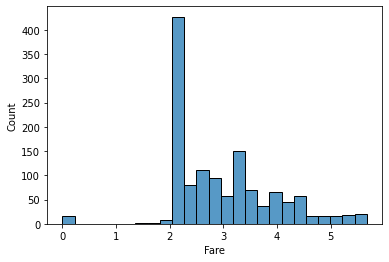

In [45]:
sns.histplot(df12.Fare)

#### 13 solution

Возможно, Cabin_First будет работать лучше, чем IsCabin. проверим

In [52]:
df13 = pd.concat([titanic, dop_features[["Cabin_First","Ticket_First_Bin", "Title_Bin"]]], axis=1).drop(["Survived", "Cabin", "Ticket",
                                                                                     "Name"], axis=1)
df13.Fare = np.log1p(df13.Fare)
df13.Parch = np.log1p(df13.Parch)
df13.SibSp = np.log1p(df13.SibSp)

In [54]:
X13 = MinMaxScaler().fit_transform(np.array(pd.get_dummies(df13[:split_index], columns=["Sex", "Embarked","Title_Bin",
                                                                                 "Ticket_First_Bin", "Cabin_First"], drop_first=True)))
get_scores(X13, ncv)

0.0 hours, 0.0 minutes and 6.85 seconds!


({'forest': 0.8327969348659003,
  'svm': 0.821455938697318,
  'xgb': 0.8282758620689654},
 0.8275095785440613)

#### 14 solution

In [63]:
df12.to_csv("vova_titanic_to_modeling.csv")

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsCabin,Ticket_First_Bin,Title_Bin
0,3,male,22.0,0.693147,0.000000,2.110213,S,0,new1,Mr
1,1,female,38.0,0.693147,0.000000,4.280593,C,1,P,Mrs
2,3,female,26.0,0.000000,0.000000,2.188856,S,0,S,Mrs
3,1,female,35.0,0.693147,0.000000,3.990834,S,1,1,Mrs
4,3,male,35.0,0.000000,0.000000,2.202765,S,0,3,Mr
...,...,...,...,...,...,...,...,...,...,...
413,3,male,26.0,0.000000,0.000000,2.202765,S,0,new1,Mr
414,1,female,39.0,0.000000,0.000000,4.699571,C,1,P,Other
415,3,male,38.5,0.000000,0.000000,2.110213,S,0,S,Mr
416,3,male,26.0,0.000000,0.000000,2.202765,S,0,3,Mr
